# Re-analysis for "A novel cortical biomarker signature predicts individual pain sensitivity"

libaries

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, roc_auc_score
import subprocess
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

set your basepath

In [4]:
# Define base path
basepath = "/home/ole/projects/PAF_reanalysis"

## Main analysis

This does the following: \
\
(1) loads in complete dataset with PAF, CME and class for all subjects. \
(2) defines models and its parameter space \
(3) splits data in independent training and test set \
(4) uses gridsearch crossvalidation in training data to fit model \
(5) uses trained models to predict data of test set \
(6) reports accuracy and AUC for both, training and test set  \

This is repeatedly done to avoid an over/underestimation of the final metrics due to the relatively low sample size for a machine learning pipeline.

Number of repetitions is set by parameter repetitions.

set number of repetitions 

In [18]:
repetitions = 100

Pipeline

In [19]:
# File paths for input data
paf_file = os.path.join(basepath, "data/PAF_all.xlsx")
cme_file = os.path.join(basepath, "data/map_volume_all.xlsx")
class_file = os.path.join(basepath, "data/class_IDs_all.xlsx")
yawn_pain_file = os.path.join(basepath, "data/yawn_pain_all.csv")
chew_pain_file = os.path.join(basepath, "data/chew_pain_all.csv")

# Load data from Excel and CSV files
df_paf = pd.read_excel(paf_file)
df_cme = pd.read_excel(cme_file)

# Calculate CME values: 1 for increase in volume, 0 otherwise
df_cme["CME"] = (df_cme["Volume_Day5"] - df_cme["Volume_Day0"]).apply(lambda x: 1 if x > 0 else 0)

# Load yawn and chew pain data, combining them
df_yawn_pain = pd.read_csv(yawn_pain_file)
df_chew_pain = pd.read_csv(chew_pain_file)
df_all_pain = df_chew_pain.add(df_yawn_pain, fill_value=0)
df_all_pain["ID"] = df_yawn_pain["ID"]

# Models and hyperparameters
models_and_params = {
    "LogisticRegression": (
        LogisticRegression(),
        {
            'model__C': np.logspace(-3, 3, 30),
            'model__solver':  ['newton-cg', 'lbfgs'],
            'model__max_iter': [200, 400, 2000, 5000]
        }
    ),
    "RandomForest": (
        RandomForestClassifier(),
        {
            'model__n_estimators': [300, 500, 1000],
            'model__max_depth': [None, 5, 10],
            'model__min_samples_split': [2, 5, 10],
            'model__bootstrap': [True, False]
        }
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(),
        {
            'model__learning_rate': [1, 0.1, 0.01, 0.01, 0.001],
            'model__max_depth': [None, 2, 5],
            'model__min_samples_split': [2, 5, 10],
            'model__n_estimators': [300, 500, 1000]
        }
    ),
    "SVC": (
        SVC(probability=True),
        {
            'model__C': [0.01, 0.1, 1, 10, 100],
            'model__gamma': ['scale', 'auto']
        }
    ),
    "MLPClassifier": (
        MLPClassifier(),
        {
            "model__alpha":[1e-3, 1e-2, 1e-1, 0, 1,10],
            "model__hidden_layer_sizes":[(100,),(100,100),(100,100,100)],
            "model__max_iter":[2000, 5000]
        }
    )
}


# Initialize results list and random seeds
results = []
random_seeds = np.random.choice(np.arange(0, 10000), size=repetitions, replace=False)

# Loop through random seeds for cross-validation
for seed in random_seeds:
    print(f"Running analysis pipeline for seed = {seed}")
    # Split the combined pain data into training and testing sets
    X_train, X_test = train_test_split(
        df_all_pain, test_size=1/3, random_state=seed
    )

    # Save split data to CSV files for further processing
    X_train.to_csv(os.path.join(basepath, "data/X_train.csv"), index=False)
    X_test.to_csv(os.path.join(basepath, "data/X_test.csv"), index=False)

    # Execute R script for LGM model
    script_path = os.path.join(basepath, "run_LGM.R")
    subprocess.run(["Rscript", script_path], capture_output=True, text=True)

    # Load classification results from R script
    df_ID_LGM_train = pd.read_csv(os.path.join(basepath, "data/Y_train.csv"))
    df_ID_LGM_test = pd.read_csv(os.path.join(basepath, "data/Y_test.csv"))

    # Merge PAF and CME data with classification results for training and testing
    data_train = df_ID_LGM_train.merge(df_paf, on="ID", how="inner").merge(
        df_cme[["ID", "CME"]], on="ID", how="inner"
    )
    data_test = df_ID_LGM_test.merge(df_paf, on="ID", how="inner").merge(
        df_cme[["ID", "CME"]], on="ID", how="inner"
    )

    # Extract features (X) and target (Y) for model training and testing
    X_train, X_test = data_train[["sensorimotor_paf", "CME"]], data_test[["sensorimotor_paf", "CME"]]
    Y_train, Y_test = data_train["class"], data_test["class"]

    # Iterate over different models and their parameter grids
    for model_name, (model, param_grid) in models_and_params.items():
        # Create a machine learning pipeline
        pipeline = Pipeline([
            ("imputer", IterativeImputer(max_iter=100, random_state=seed)),
            ("scaler", StandardScaler()),
            ("model", model)
        ])

        # Perform grid search cross-validation
        search = GridSearchCV(
            pipeline, param_grid=param_grid, cv=5,
            scoring="accuracy", verbose=0, n_jobs=-1
        )
        search.fit(X_train, Y_train)

        # Evaluate the best model on training and testing datasets
        best_model = search.best_estimator_
        for dataset, X_eval, y_eval, label in zip(
            ["train", "test"], [X_train, X_test], [Y_train, Y_test], ["Training", "Test"]
        ):
            y_pred = best_model.predict(X_eval)
            y_pred_proba = best_model.predict_proba(X_eval)[:, 1]
            accuracy = accuracy_score(y_eval, y_pred)
            auc = roc_auc_score(y_eval, y_pred_proba)
            results.append({
                "Seed": seed,
                "Model": model_name,
                "Dataset": label,
                "Accuracy": accuracy,
                "AUC": auc
            })

# Convert results to DataFrame for aggregation and saving
results_df = pd.DataFrame(results)

# Aggregate results by model and dataset
summary = results_df.groupby(["Model", "Dataset"]).mean()[["Accuracy", "AUC"]].reset_index()

# Save detailed and summary results to CSV files
results_path = os.path.join(basepath, "results")
os.makedirs(results_path, exist_ok=True)
results_df.to_csv(os.path.join(results_path, "results_all_runs.csv"), index=False)
summary.to_csv(os.path.join(results_path, "summary_results.csv"), index=False)

print("Analysis complete. Results saved.")


Running analysis pipeline for seed = 547


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 7777
Running analysis pipeline for seed = 7013
Running analysis pipeline for seed = 3258


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 1523
Running analysis pipeline for seed = 3756
Running analysis pipeline for seed = 3236
Running analysis pipeline for seed = 6003


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 7646
Running analysis pipeline for seed = 5772
Running analysis pipeline for seed = 7400


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 257


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 2249
Running analysis pipeline for seed = 8767
Running analysis pipeline for seed = 7060


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 776


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 9272
Running analysis pipeline for seed = 8881


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 417
Running analysis pipeline for seed = 2168
Running analysis pipeline for seed = 5604


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 9782
Running analysis pipeline for seed = 8365
Running analysis pipeline for seed = 6605
Running analysis pipeline for seed = 7506
Running analysis pipeline for seed = 2216
Running analysis pipeline for seed = 8553


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 8009
Running analysis pipeline for seed = 8972


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 6186


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 7025


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 7982


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 6640
Running analysis pipeline for seed = 3826


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 5266


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 8669


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 4963
Running analysis pipeline for seed = 3811


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 1708


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 8645
Running analysis pipeline for seed = 7353
Running analysis pipeline for seed = 4372
Running analysis pipeline for seed = 102
Running analysis pipeline for seed = 439


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 6885


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 4383


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 7600
Running analysis pipeline for seed = 6253
Running analysis pipeline for seed = 311
Running analysis pipeline for seed = 2254
Running analysis pipeline for seed = 6890
Running analysis pipeline for seed = 2755
Running analysis pipeline for seed = 2819
Running analysis pipeline for seed = 6146
Running analysis pipeline for seed = 9251


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 5493
Running analysis pipeline for seed = 7707
Running analysis pipeline for seed = 1071
Running analysis pipeline for seed = 4528


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 5488
Running analysis pipeline for seed = 7406
Running analysis pipeline for seed = 1322
Running analysis pipeline for seed = 8651
Running analysis pipeline for seed = 6548
Running analysis pipeline for seed = 9753


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 3315
Running analysis pipeline for seed = 1238
Running analysis pipeline for seed = 6229
Running analysis pipeline for seed = 6626
Running analysis pipeline for seed = 1591
Running analysis pipeline for seed = 991
Running analysis pipeline for seed = 5231
Running analysis pipeline for seed = 4907


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 7062
Running analysis pipeline for seed = 4241
Running analysis pipeline for seed = 6554


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 6977


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 6717


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 9386


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 718
Running analysis pipeline for seed = 3735
Running analysis pipeline for seed = 8359
Running analysis pipeline for seed = 7151
Running analysis pipeline for seed = 170
Running analysis pipeline for seed = 4487


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 2337
Running analysis pipeline for seed = 3752
Running analysis pipeline for seed = 7452
Running analysis pipeline for seed = 9366
Running analysis pipeline for seed = 7489
Running analysis pipeline for seed = 2028


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 4457
Running analysis pipeline for seed = 3515
Running analysis pipeline for seed = 9260
Running analysis pipeline for seed = 9420
Running analysis pipeline for seed = 4496
Running analysis pipeline for seed = 5343


/home/ole/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Running analysis pipeline for seed = 5153
Running analysis pipeline for seed = 7890
Running analysis pipeline for seed = 5956
Analysis complete. Results saved.


## Create plots for accuracy and AUC for all models 
\
Plot will only display the average for both metrics across all repetitions of the pipeline

In [24]:
# Define the order of the Dataset categories
hue_order = ["Training", "Test"]

# Melt the DataFrame for easier plotting
plot_df = summary.melt(id_vars=["Model", "Dataset"], value_vars=["Accuracy", "AUC"], 
                       var_name="Metric", value_name="Score")

# Create the bar plot for Accuracy and AUC
for metric in ["Accuracy", "AUC"]:
    plt.figure(figsize=(12, 10))
    sns.barplot(
        data=plot_df[plot_df["Metric"] == metric],
        x="Score",
        y="Model",
        hue="Dataset",
        hue_order=hue_order,  # Ensure Training is always left and Test is right
        palette={"Training": "#9fc8c8", "Test": "#298c8c"}  # Adjust colors
    )

    # Add values on bars
    for container in plt.gca().containers:
        labels = [f"{v.get_width():.2f}" for v in container]
        plt.gca().bar_label(container, labels=labels, label_type='edge', fontsize=14)

    # Add title and labels
    plt.title(f"{metric} by Model", fontsize=20, fontweight="bold")
    plt.xlabel(metric, fontsize=16)
    plt.ylabel("Model", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(title="Dataset", fontsize=14, title_fontsize=16, loc="lower right")

    # Remove grid lines
    plt.gca().grid(False)
    plt.gca().spines["left"].set_linewidth(0.5)
    plt.gca().spines["bottom"].set_linewidth(0.5)

    # Save the figure as an SVG
    filename = os.path.join(basepath, f"figures/{metric}_by_Model.svg")
    plt.tight_layout()
    plt.savefig(filename, format="svg")
    plt.close()  # Close the plot to avoid overlap

    print(f"Saved {metric} plot as SVG: {filename}")


Saved Accuracy plot as SVG: /home/ole/projects/PAF_reanalysis/figures/Accuracy_by_Model.svg
Saved AUC plot as SVG: /home/ole/projects/PAF_reanalysis/figures/AUC_by_Model.svg


## Create histogram of test set metrics (for different random seeds)

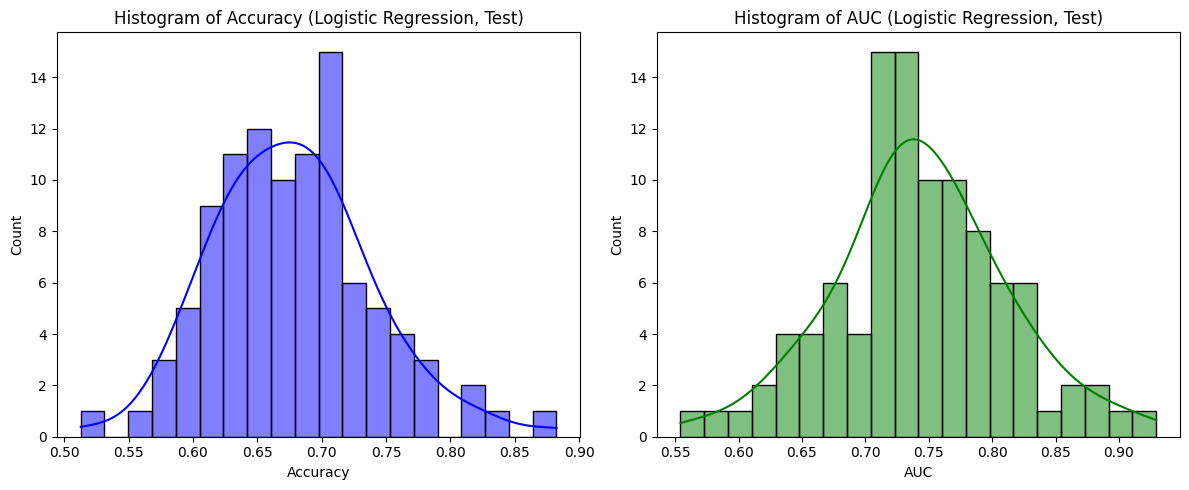

In [12]:
# Load the data
file_path = os.path.join(basepath,"results/results_all_runs.csv")
results_df = pd.read_csv(file_path)

# Filter for LogisticRegression on Test dataset
logreg_test_df = results_df[(results_df["Model"] == "LogisticRegression") & (results_df["Dataset"] == "Test")]

# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy histogram
sns.histplot(logreg_test_df["Accuracy"], bins=20, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Histogram of Accuracy (Logistic Regression, Test)")
axes[0].set_xlabel("Accuracy")
axes[0].set_ylabel("Count")

# Plot AUC histogram
sns.histplot(logreg_test_df["AUC"], bins=20, kde=True, ax=axes[1], color="green")
axes[1].set_title("Histogram of AUC (Logistic Regression, Test)")
axes[1].set_xlabel("AUC")
axes[1].set_ylabel("Count")

plt.savefig(os.path.join(basepath, "figures/Metrics_testset_histogram.svg"), format="svg")

# Show plots
plt.tight_layout()
plt.show()


